In [1]:
from google.colab import drive
drive.mount('/content/drive')
'!cp drive/MyDrive/helpers.py .'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'!cp drive/MyDrive/helpers.py .'

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import get_data_loaders, seed_all, anomaly_detection_display
import pandas as pd
import multiprocessing

In [3]:
# Ensure repeatability
seed_all(42)

# Get data loaders for the MNIST dataset for train, validation, and test dataset
data_loaders = get_data_loaders(batch_size=1024)

# Set the device to CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


In [4]:
# Model Definition
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        # The encoder part of the autoencoder takes the input image and applies
        # a series of convolutional layers and pooling layers to reduce its dimensionality,
        # encoding the input image into a smaller, dense representation.
        self.encoder = nn.Sequential(
            # First convolutional layer with 32 filters, kernel size of 3, stride of 1, and padding of 1.
            # This preserves the spatial dimensions of the input (28x28 for MNIST) after convolution.
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),  # ReLU activation function for introducing non-linearity.
            nn.MaxPool2d(2, 2),  # Max pooling with a 2x2 window and stride of 2, reducing dimensions by half.

            # Second convolutional layer, further compressing the representation.
            # Here, we reduce the channel size to 16 for more compact representation.
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),  # ReLU activation function.
            nn.MaxPool2d(2, 2),  # Another max pooling layer, halving the dimensions again.
        )

        # Decoder
        # The decoder part of the autoencoder aims to reconstruct the original image
        # from the encoded representation, gradually increasing its dimensionality
        # through transposed convolutions.
        self.decoder = nn.Sequential(
            # First transposed convolutional layer that starts the process of upsampling,
            # converting the dense representation back towards the original dimensionality.
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),  # ReLU activation function.

            # Second transposed convolutional layer that further upsamples the representation
            # and reduces the channel size back to 1, aiming to reconstruct the original image.
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.Sigmoid(),  # Sigmoid activation function to ensure the output values are between 0 and 1,
                           # since the images are normalized in this range.
        )

    def forward(self, x):
        # Encoding phase: passing the input through the encoder to get the compressed representation.
        x = self.encoder(x)
        # Decoding phase: trying to reconstruct the original input from its encoded form.
        x = self.decoder(x)
        return x


In [5]:
# Initializing the Autoencoder model and moving it to the available device (GPU or CPU).
# This step ensures that all computations for the model are performed on the specified device,
# enhancing computational efficiency, especially on GPU for deep learning models.
model = Autoencoder().to(device)

# Loss and Optimizer Setup:
# criterion - Defines the loss function. Here, Mean Squared Error (MSE) loss is used,
# which is common for regression tasks and autoencoders where the goal is to minimize
# the difference between the original and reconstructed images.
criterion = nn.MSELoss()

# optimizer - Defines the optimization algorithm used to update model weights.
# Adam is a popular choice due to its efficiency and adaptive learning rate properties.
# The learning rate (lr) is set to 0.001, which is a common starting value for many tasks.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Setup with Early Stopping and Monitoring Losses:
# n_epochs - Number of epochs to train the model. An epoch is a complete pass through
# the entire training dataset.
n_epochs = 10

# patience - Number of epochs with no improvement in validation loss after which training is stopped.
# This is a mechanism to prevent overfitting by stopping the training early if the model
# stops improving on the validation set.
patience = 5

# best_loss - Initialized as infinity. This variable will track the lowest validation loss
# observed during training. It is used in conjunction with patience for early stopping.
best_loss = np.inf

# patience_counter - Counts the number of consecutive epochs without improvement in validation loss.
# If this reaches the 'patience' threshold, training is stopped early.
patience_counter = 0

# Initialize lists to store loss values for visualizing the training process:
# epoch_train_losses - Stores the total training loss for each epoch. This is useful for
# monitoring the model's learning progress over time.
epoch_train_losses = []

# epoch_val_losses - Stores the total validation loss for each epoch. Monitoring validation loss
# is crucial for identifying overfitting and making decisions about early stopping.
epoch_val_losses = []


In [6]:
# Main training loop for the specified number of epochs.
for epoch in range(n_epochs):
    # Set the model to training mode. This enables features like dropout and batch normalization.
    model.train()
    # Initialize the total training loss for this epoch.
    train_loss = 0.0

    # Iterate over the training data loader. tqdm is used to display a progress bar for user convenience.
    for data in tqdm(data_loaders['train'], desc="Training", leave=False):
        images, _ = data  # Unpack the data. Labels are not used hence assigned to _.
        images = images.to(device)  # Move images to the configured device.

        # Forward pass: Compute the predicted outputs by passing the images through the model.
        outputs = model(images)
        # Calculate the loss between the predicted outputs and the original images.
        loss = criterion(outputs, images)

        # Backward pass and optimize:
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors.
        loss.backward()  # Compute gradient of the loss with respect to model parameters.
        optimizer.step()  # Perform a single optimization step (parameter update).

        # Accumulate the training loss over all batches for this epoch.
        train_loss += loss.item() * images.size(0)

    # Validation phase:
    # Set the model to evaluation mode. This disables features like dropout and batch normalization.
    model.eval()
    # Initialize the total validation loss for this epoch.
    val_loss = 0.0
    with torch.no_grad():  # Disables gradient calculation to save memory and computations.
        for data in tqdm(data_loaders['valid'], desc="Validating", leave=False):
            images, _ = data  # Unpack the data. Labels are not used hence assigned to _.
            images = images.to(device)  # Move images to the configured device.

            # Forward pass: Compute the predicted outputs by passing the images through the model.
            outputs = model(images)
            # Calculate the loss between the predicted outputs and the original images.
            loss = criterion(outputs, images)

            # Accumulate the validation loss over all batches for this epoch.
            val_loss += loss.item() * images.size(0)

    # Calculate the average losses for this epoch.
    train_loss /= len(data_loaders['train'].dataset)
    val_loss /= len(data_loaders['valid'].dataset)
    # Print the average training and validation losses for this epoch.
    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # Append the average losses to their respective lists for later analysis.
    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)

    # Early Stopping Check:
    if val_loss < best_loss:
        best_loss = val_loss  # Update the best observed validation loss.
        patience_counter = 0  # Reset the patience counter because we found a better model.
    else:
        patience_counter += 1  # Increment the patience counter if no improvement.
        if patience_counter >= patience:  # If patience limit is reached, stop training.
            print("Early stopping triggered.")
            break

# Note: Additional steps for testing the model and anomaly detection on test data would follow here.


Epoch [1/10], Train Loss: 0.2105, Valid Loss: 0.1060


Epoch [2/10], Train Loss: 0.0658, Valid Loss: 0.0431


Epoch [3/10], Train Loss: 0.0349, Valid Loss: 0.0252


Epoch [4/10], Train Loss: 0.0195, Valid Loss: 0.0162


Epoch [5/10], Train Loss: 0.0146, Valid Loss: 0.0131


Epoch [6/10], Train Loss: 0.0120, Valid Loss: 0.0109


Epoch [7/10], Train Loss: 0.0101, Valid Loss: 0.0095


Epoch [8/10], Train Loss: 0.0090, Valid Loss: 0.0086


Epoch [9/10], Train Loss: 0.0082, Valid Loss: 0.0079


Epoch [10/10], Train Loss: 0.0076, Valid Loss: 0.0073


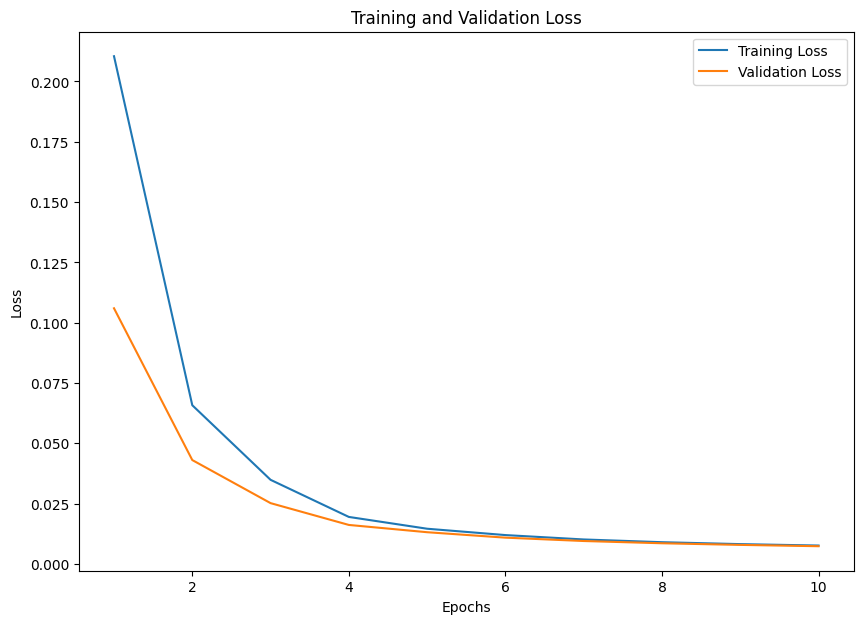

In [7]:
# Plotting the training and validation loss curves
plt.figure(figsize=(10, 7))  # Create a new figure with specified figure size
plt.plot(range(1, n_epochs + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), epoch_val_losses, label='Validation Loss')


# Setting the label for the x-axis.
plt.xlabel('Epochs')  # Label the x-axis as "Epochs"
# Setting the label for the y-axis.
plt.ylabel('Loss')  # Label the y-axis as "Loss"

# Adding a legend to differentiate between training and validation loss lines
plt.legend()  # Show a legend to label the training and validation lines

# Adding a title to the plot
plt.title('Training and Validation Loss')  # Set the title of the plot

# Display the plot
plt.show()  # Render the plot so it's visible


Testing: 100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


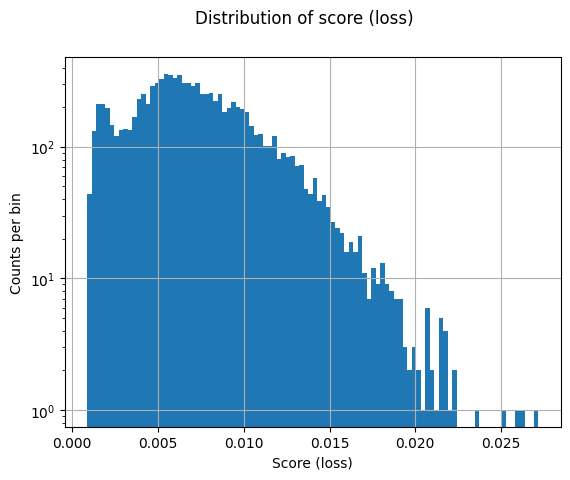

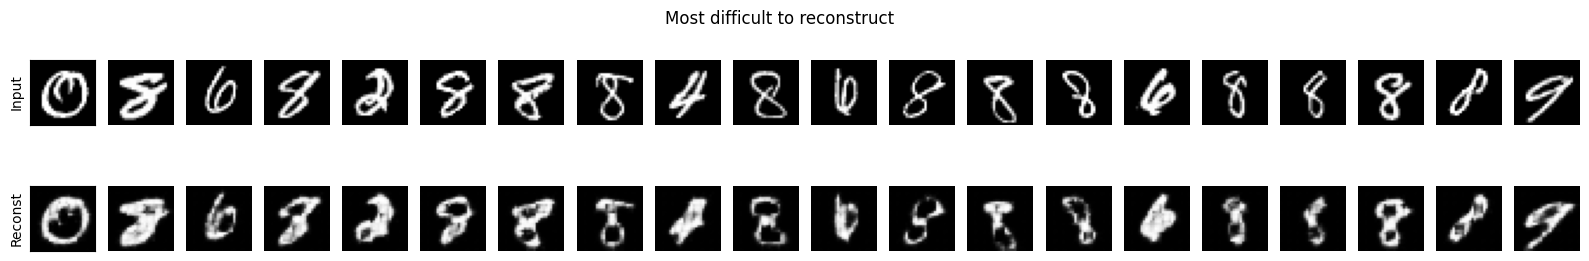

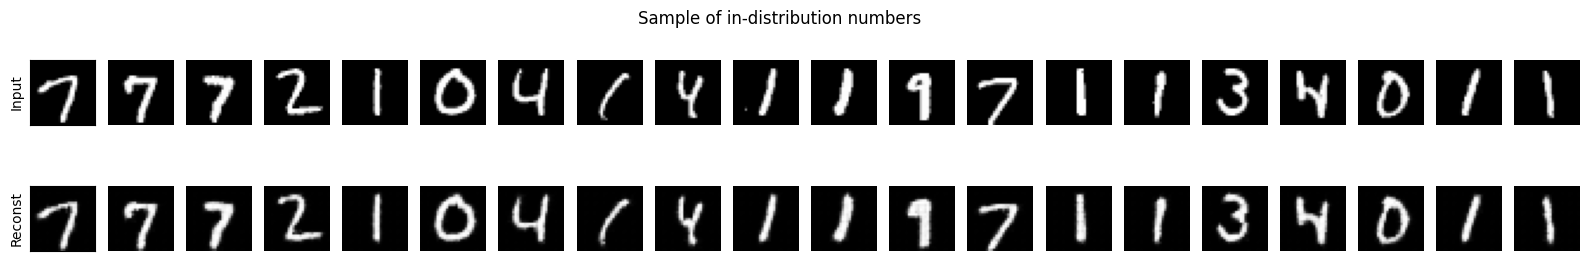

In [8]:
# Testing loop to evaluate the model
losses = {}  # Dictionary to store losses and reconstructed images for each test sample.
loss_no_reduction = nn.MSELoss(reduction='none')  # Use a version of the loss function that does not reduce the batch losses to a single value.

idx = 0  # Initialize an index counter to keep track of the current sample index across batches.

with torch.no_grad():  # Disable gradient calculation to save memory and computations.
    for data in tqdm(desc="Testing", total=len(data_loaders['test']), iterable=data_loaders['test']):  # Iterate over the test dataset.
        images, _ = data  # Unpack the data, ignoring the labels since they're not needed for reconstruction.
        images = images.to(device)  # Move the images to the current device (GPU or CPU).
        outputs = model(images)  # Forward pass: compute the reconstructed images.
        loss = loss_no_reduction(outputs, images)  # Compute the loss for each image in the batch without reduction.

        # Prepare the images and outputs for storage by moving them to CPU if necessary.
        if torch.cuda.is_available():
            images = images.cpu()
            outputs = outputs.cpu()

        # Accumulate the losses and images for analysis.
        for i, l in enumerate(loss.mean(dim=[1, 2, 3])):  # Calculate the mean loss per image.
            losses[idx + i] = {  # Store the per-image loss and the original and reconstructed images in the dictionary.
                'loss': float(l.cpu().numpy()),  # Store the loss as a float.
                'image': images[i].numpy(),  # Convert the tensor to a NumPy array for the original image.
                'reconstructed': outputs[i].numpy()  # Convert the tensor to a NumPy array for the reconstructed image.
            }

        idx += loss.shape[0]  # Update the index counter by the number of images in the current batch.

# Store results in a pandas DataFrame
df = pd.DataFrame(losses).T  # Transpose the dictionary to a DataFrame for easier analysis.

# Display anomaly detection results
anomaly_detection_display(df)  # Call a function to display the results, potentially identifying anomalies based on reconstruction loss.
